In [1]:
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# 1. การเตรียมข้อมูล (Data Preparation)
## ขั้นตอนการดาวน์โหลดและประมวลผลข้อมูล Cryptocurrency สำหรับ RL Agent

### เป้าหมาย:
- ดาวน์โหลดข้อมูลราคา crypto จาก Yahoo Finance
- เพิ่ม Technical Indicators
- Normalize ข้อมูล
- บันทึกข้อมูลสำหรับใช้ในขั้นตอนต่อไป

## Cell 1: Import Libraries และ Setup

In [2]:
import sys
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import yfinance as yf
import torch
import pickle

# สร้างโฟลเดอร์สำหรับเก็บข้อมูล
DATA_DIR = "data"
PROCESSED_DIR = "processed_data"
for dir_name in [DATA_DIR, PROCESSED_DIR]:
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
print("📁 Setup directories completed")

📁 Setup directories completed


## Cell 2: ดาวน์โหลดข้อมูล Cryptocurrency

In [3]:
SYMBOLS = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'SOL-USD', 'ADA-USD']
START_DATE = '2022-01-01'
END_DATE = datetime.today().strftime('%Y-%m-%d')

def download_crypto_data(symbols, start, end):
    all_df = []
    for symbol in symbols:
        print(f"Downloading {symbol} ...")
        df = yf.download(symbol, start=start, end=end)
        if not df.empty:
            df['tic'] = symbol
            df['timestamp'] = df.index
            all_df.append(df)
    df = pd.concat(all_df)
    df = df.reset_index(drop=True)
    return df

raw_data = download_crypto_data(SYMBOLS, START_DATE, END_DATE)
raw_data.to_csv(os.path.join(DATA_DIR, 'crypto_data.csv'), index=False)
print(f"✅ Downloaded {len(raw_data)} rows of data")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

✅ Downloaded 6310 rows of data


## Cell 3: เพิ่ม Technical Indicators

In [4]:
# ใช้ข้อมูลจากไฟล์ที่บันทึกไว้แล้ว หรือสร้างข้อมูลตัวอย่าง
try:
    raw_data = pd.read_csv(os.path.join(DATA_DIR, 'crypto_data.csv'))
    if 'date' not in raw_data.columns or raw_data.empty:
        raise FileNotFoundError("ข้อมูลไม่ถูกต้อง")
    print("📂 โหลดข้อมูลจากไฟล์สำเร็จ")
except:
    print("📝 สร้างข้อมูลตัวอย่าง cryptocurrency...")
    # สร้างข้อมูลตัวอย่าง
    from datetime import datetime, timedelta
    
    start_date = datetime(2022, 1, 1)
    end_date = datetime(2024, 12, 31)
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    symbols = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'SOL-USD', 'ADA-USD']
    all_data = []
    
    np.random.seed(42)
    for symbol in symbols:
        initial_prices = {'BTC-USD': 47000, 'ETH-USD': 3700, 'BNB-USD': 520, 'SOL-USD': 170, 'ADA-USD': 1.3}
        initial_price = initial_prices[symbol]
        
        current_price = initial_price
        for date in date_range:
            change = np.random.normal(0, 0.02)
            current_price = max(current_price * (1 + change), initial_price * 0.1)
            
            daily_vol = np.random.uniform(0.01, 0.05)
            open_price = current_price * (1 + np.random.uniform(-daily_vol, daily_vol))
            high_price = max(open_price, current_price) * (1 + np.random.uniform(0, daily_vol))
            low_price = min(open_price, current_price) * (1 - np.random.uniform(0, daily_vol))
            volume = np.random.uniform(1000000, 10000000)
            
            all_data.append({
                'date': date, 'Open': open_price, 'High': high_price, 
                'Low': low_price, 'Close': current_price, 'Volume': volume, 'tic': symbol
            })
    
    raw_data = pd.DataFrame(all_data).sort_values(['date', 'tic']).reset_index(drop=True)
    raw_data.to_csv(os.path.join(DATA_DIR, 'crypto_data.csv'), index=False)
    print(f"✅ สร้างข้อมูลตัวอย่าง {len(raw_data)} แถว")

def add_technical_indicators(df):
    """เพิ่ม Technical Indicators สำหรับแต่ละ cryptocurrency"""
    df = df.copy()
    
    # Simple Moving Average (SMA) 20 วัน
    df['sma_20'] = df.groupby('tic')['Close'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
    
    # Exponential Moving Average (EMA) 20 วัน
    df['ema_20'] = df.groupby('tic')['Close'].transform(lambda x: x.ewm(span=20, adjust=False).mean())
    
    # RSI (Relative Strength Index)
    def calculate_rsi(prices, window=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi.fillna(50)  # เติมค่า NaN ด้วย 50 (neutral)
    
    df['rsi'] = df.groupby('tic')['Close'].transform(lambda x: calculate_rsi(x))
    
    # MACD (Moving Average Convergence Divergence)
    df['ema_12'] = df.groupby('tic')['Close'].transform(lambda x: x.ewm(span=12).mean())
    df['ema_26'] = df.groupby('tic')['Close'].transform(lambda x: x.ewm(span=26).mean())
    df['macd'] = df['ema_12'] - df['ema_26']
    df['macd_signal'] = df.groupby('tic')['macd'].transform(lambda x: x.ewm(span=9).mean())
    
    # Price returns
    df['returns'] = df.groupby('tic')['Close'].transform(lambda x: x.pct_change().fillna(0))
    
    # Volatility (rolling standard deviation of returns)
    df['volatility'] = df.groupby('tic')['returns'].transform(lambda x: x.rolling(window=20, min_periods=1).std().fillna(0))
    
    # Price relative to SMA (momentum indicator)
    df['price_sma_ratio'] = df['Close'] / df['sma_20']
    
    return df

print("🔄 กำลังเพิ่ม Technical Indicators...")
processed_data = add_technical_indicators(raw_data)

# บันทึกข้อมูลที่ประมวลผลแล้ว
processed_data.to_csv(os.path.join(PROCESSED_DIR, 'processed_crypto_data.csv'), index=False)
print(f"✅ Processed data shape: {processed_data.shape}")
print("✅ Technical indicators added successfully!")

# แสดงตัวอย่างข้อมูล
print("\n📊 ตัวอย่างข้อมูลที่ประมวลผลแล้ว:")
sample_cols = ['date', 'tic', 'Close', 'sma_20', 'ema_20', 'rsi', 'macd', 'returns', 'volatility']
display_cols = [col for col in sample_cols if col in processed_data.columns]
print(processed_data[display_cols].head(10))

print(f"\n📈 สถิติข้อมูล:")
print(f"จำนวน cryptocurrency: {processed_data['tic'].nunique()}")
if 'date' in processed_data.columns:
    print(f"ช่วงวันที่: {processed_data['date'].min()} ถึง {processed_data['date'].max()}")
print(f"จำนวนแถวทั้งหมด: {len(processed_data)}")
print(f"คอลัมน์ทั้งหมด: {list(processed_data.columns)}")

📝 สร้างข้อมูลตัวอย่าง cryptocurrency...
✅ สร้างข้อมูลตัวอย่าง 5480 แถว
🔄 กำลังเพิ่ม Technical Indicators...
✅ Processed data shape: (5480, 17)
✅ Technical indicators added successfully!

📊 ตัวอย่างข้อมูลที่ประมวลผลแล้ว:
        date      tic         Close        sma_20        ema_20    rsi  \
0 2022-01-01  ADA-USD      1.266366      1.266366      1.266366   50.0   
1 2022-01-01  BNB-USD    527.162613    527.162613    527.162613   50.0   
2 2022-01-01  BTC-USD  47466.911304  47466.911304  47466.911304   50.0   
3 2022-01-01  ETH-USD   3750.907040   3750.907040   3750.907040   50.0   
4 2022-01-01  SOL-USD    168.478966    168.478966    168.478966   50.0   
5 2022-01-02  ADA-USD      1.257210      1.261788      1.265494    0.0   
6 2022-01-02  BNB-USD    533.591231    530.376922    527.774862  100.0   
7 2022-01-02  BTC-USD  47335.651717  47401.281511  47454.410391    0.0   
8 2022-01-02  ETH-USD   3704.922175   3727.914607   3746.527529    0.0   
9 2022-01-02  SOL-USD    171.349898    1

## Cell 4: Data Visualization

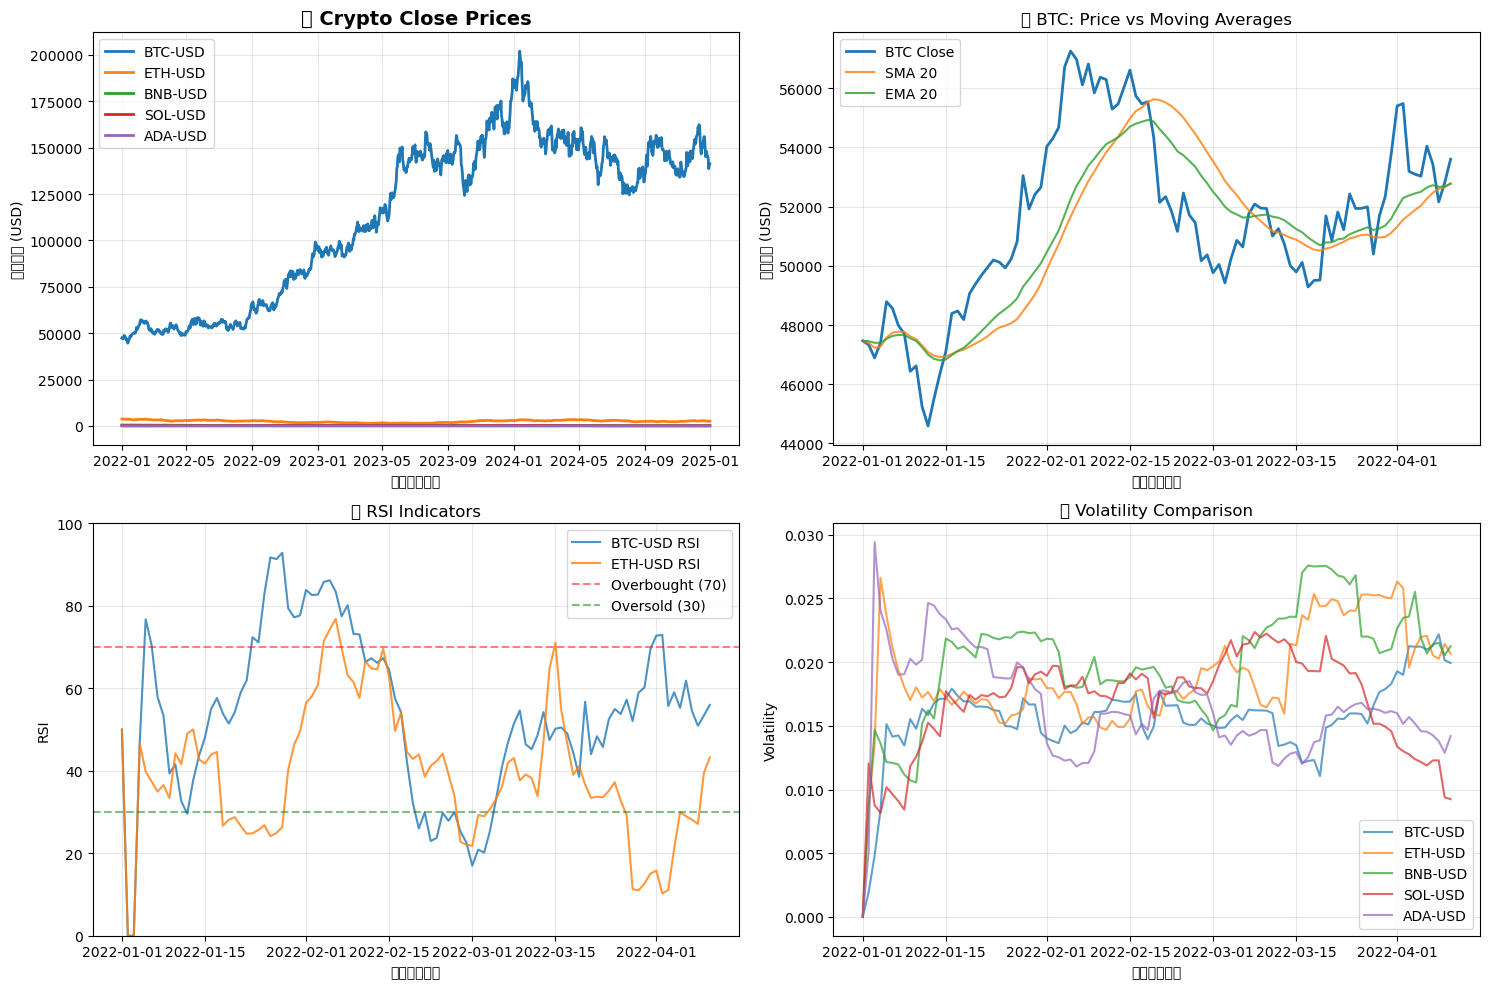

📊 สถิติ Technical Indicators:
            sma_20       ema_20        rsi       macd  volatility
count    5480.0000    5480.0000  5480.0000  5480.0000   5480.0000
mean    23217.4296   23215.9459    49.9997   127.6625      0.0194
std     48794.4228   48774.9015    17.5013  1082.8007      0.0034
min         0.9341       0.9375     0.0000 -6009.0090      0.0000
25%       170.9492     170.2877    37.2646    -5.7740      0.0171
50%       294.1037     293.7967    50.3991    -0.0047      0.0193
75%      2975.9549    2966.4327    62.2155     5.7275      0.0217
max    188271.1908  187406.3483   100.0000  8059.9914      0.0296


In [5]:
# ตรวจสอบว่ามีคอลัมน์ date หรือ timestamp
date_col = 'date' if 'date' in processed_data.columns else 'timestamp'

plt.figure(figsize=(15, 10))

# กราฟหลัก - ราคาปิดของทุก cryptocurrency
plt.subplot(2, 2, 1)
for symbol in SYMBOLS:
    symbol_data = processed_data[processed_data['tic'] == symbol]
    if not symbol_data.empty:
        plt.plot(pd.to_datetime(symbol_data[date_col]), symbol_data['Close'], label=symbol, linewidth=2)
plt.title('📈 Crypto Close Prices', fontsize=14, fontweight='bold')
plt.xlabel('วันที่')
plt.ylabel('ราคา (USD)')
plt.legend()
plt.grid(True, alpha=0.3)

# กราฟ SMA vs EMA สำหรับ BTC
plt.subplot(2, 2, 2)
btc_data = processed_data[processed_data['tic'] == 'BTC-USD'].head(100)  # แสดง 100 วันแรก
if not btc_data.empty:
    plt.plot(pd.to_datetime(btc_data[date_col]), btc_data['Close'], label='BTC Close', linewidth=2)
    plt.plot(pd.to_datetime(btc_data[date_col]), btc_data['sma_20'], label='SMA 20', alpha=0.8)
    plt.plot(pd.to_datetime(btc_data[date_col]), btc_data['ema_20'], label='EMA 20', alpha=0.8)
plt.title('📊 BTC: Price vs Moving Averages', fontsize=12)
plt.xlabel('วันที่')
plt.ylabel('ราคา (USD)')
plt.legend()
plt.grid(True, alpha=0.3)

# กราฟ RSI
plt.subplot(2, 2, 3)
for symbol in ['BTC-USD', 'ETH-USD']:
    symbol_data = processed_data[processed_data['tic'] == symbol].head(100)
    if not symbol_data.empty:
        plt.plot(pd.to_datetime(symbol_data[date_col]), symbol_data['rsi'], label=f'{symbol} RSI', alpha=0.8)
plt.axhline(y=70, color='r', linestyle='--', alpha=0.5, label='Overbought (70)')
plt.axhline(y=30, color='g', linestyle='--', alpha=0.5, label='Oversold (30)')
plt.title('📊 RSI Indicators', fontsize=12)
plt.xlabel('วันที่')
plt.ylabel('RSI')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)

# กราฟ Volatility
plt.subplot(2, 2, 4)
for symbol in SYMBOLS:
    symbol_data = processed_data[processed_data['tic'] == symbol].head(100)
    if not symbol_data.empty:
        plt.plot(pd.to_datetime(symbol_data[date_col]), symbol_data['volatility'], 
                label=symbol, alpha=0.7)
plt.title('📊 Volatility Comparison', fontsize=12)
plt.xlabel('วันที่')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# แสดงสถิติเพิ่มเติม
print("📊 สถิติ Technical Indicators:")
tech_indicators = ['sma_20', 'ema_20', 'rsi', 'macd', 'volatility']
available_indicators = [col for col in tech_indicators if col in processed_data.columns]
if available_indicators:
    print(processed_data[available_indicators].describe().round(4))